# Micro Doppler

You can open this workbook in Google Colab to experiment with mmWrt 
[![](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/matt-chv/mmWrt/blob/main/docs/micro_doppler.ipynb)

Below is an intro to mmWrt for simple micro doppler estimation


In [1]:
# Install a pip package in the current Jupyter kernel
import sys
from os.path import abspath, basename, join, pardir
import datetime

# hack to handle if running from git cloned folder or stand alone (like Google Colab)
cw = basename(abspath(join(".")))
dp = abspath(join(".",pardir))
if cw=="docs" and basename(dp) == "mmWrt":
    # running from cloned folder
    print("running from git folder, using local path (latest) mmWrt code", dp)
    sys.path.insert(0, dp)
else:
    print("running standalone, need to ensure mmWrt is installed")
    !{sys.executable} -m pip install mmWrt
print(datetime.datetime.now())

running from git folder, using local path (latest) mmWrt code c:\git\mmWrt
2023-09-30 18:30:41.707067


In [2]:
from os.path import abspath, join, pardir
import sys
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import colors
from numpy import arange, array, where, expand_dims, sin, pi
from scipy.signal import stft

from mmWrt.Raytracing import rt_points  # noqa: E402
from mmWrt.Scene import Radar, Transmitter, Receiver, Target  # noqa: E402
from mmWrt import RadarSignalProcessing as rsp  # noqa: E402

bw 1000000.0
rx fmin 60.0
rx fmax 60.001
tx fmin 60.0
tx fmax 60.001
t_ic vs f1 199999.99999999997 6
n*t_ic vs 1/f1 0.01024 0.3333333333333333
t2 pos at t=0 (500.05, 0, 500)
t-1 0.01024
t2 pos at t=-1 (500.0490714754493, 0, 500)
v0 0
v1 0.0
Generic observations about the simulation
Compute: True
Radar freq: 60.0 GHz
range resolution 150.0
Range resolution target vs actual 50 150.0
Tc 0.00125
T-1 - T0 0.0011999999999998678
Dmax 187500.0
Dmax as function fs 3750.0
radar lambda: 0.005
vmax :249.99999999999997
speed resolution intra-frame: 2.0
speed resolution interframe: 0.0009765625
---- TARGETS ---
IF frequency for target[0] is 3771.2361663282536, which is 0.19 of fs
!!!!!! target[0] covers less than one range: 0.0 < 150.0 (range resolution)
End of simulation time: 2.571440000000012
IF frequency for target[1] is 3771.2361663282536, which is 0.19 of fs
!!!!!! target[1] covers less than one range: 0.04874879128988141 < 150.0 (range resolution)
End of simulation time: 2.571440000000012
IF 

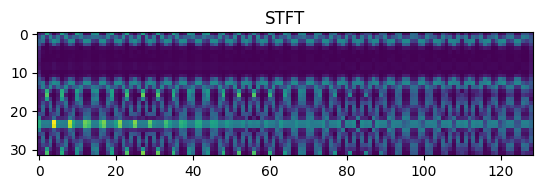

In [80]:
# DO NOT CHANGE ANYMORE 
# !!!!!
from scipy.fft import fft, fft2
c = 3e8

debug_ON = True
compute_raytracing = False
test = 0
NC=2048
bw = 1e6
print("bw", bw)

t_ic = 1/2e5 #1.2e-6
f0m = 60e9
fs_if = 20e3
k=800e6
radar = Radar(transmitter=Transmitter(bw=bw, slope=k,
                                      f0_min=f0m,
                                      t_inter_chirp=t_ic,
                                      chirps_count=NC),
              receiver=Receiver(fs=fs_if, max_adc_buffer_size=60000,
                                debug=debug_ON), debug=debug_ON)

x0, y0, z0 = 500, 0, 500
f1 = 3
v0=0
# assert 1/t_ic > 2* f1
print("t_ic vs f1", 1/t_ic, 2*f1)
print("n*t_ic vs 1/f1", NC*t_ic, 1/f1)
xt0 = lambda t: v0*t 
xt1 = lambda t: xt0(t) + 0.05*sin(2*pi*f1*t)
xt2 = lambda t: xt0(t) + 0.05*sin(2*pi*f1*t + pi/2)
xt3 = lambda t: xt0(t) + 0.05*sin(2*pi*f1*t + pi)
xt4 = lambda t: xt0(t) + 0.05*sin(2*pi*f1*t + 3*pi/2)
target0 = Target(x0, 0, z0, xt=lambda t: xt0(t))
target1 = Target(x0, 0, z0, xt=lambda t: xt1(t))
target2 = Target(x0, 0, z0, xt=lambda t: xt2(t))
target3 = Target(x0, 0, z0, xt=lambda t: xt3(t))
target4 = Target(x0, 0, z0, xt=lambda t: xt4(t))

t0 = 0
tm1 = NC*t_ic

print("t2 pos at t=0",target2.pos_t(t=0))
print("t-1",NC*t_ic)
print("t2 pos at t=-1",target2.pos_t(t=tm1))
print("v0",xt0(0))
print("v1",xt0(tm1))
targets_s =  [target0, target1, target2, target3, target4]
#targets_s = [target1]
# targets_s = [target0]

opt = {"compute":True, "Dres_min":50}

bb = rt_points(radar, targets=targets_s, debug=debug_ON, raytracing=opt)

def plot_range_doppler(cube2D, lambda0_max, t_chirp_to_chirp=t_ic, fs=fs_if, k=k, 
                       n_label_r=10,
                       n_label_d=5,
                       D_max=-1,
                       transpose=False):

    Z_fft2 = abs(fft2(cube2D))
    n_chirps, n_samples =  Z_fft2.shape
    
    # change scale for 2D plot
    # inspired by https://stackoverflow.com/a/53746824

    # range formula
    x_step = fs*c/2/k/n_samples
    if isinstance(cube[0,0], complex):
        d_max = fs*c/2/k
    else:
        d_max = fs*c/4/k
    if D_max>0:
        x_ratio = D_max/d_max
    else:
        x_ratio = 1
    print(60, x_ratio)

    ranges = arange(0, fs*c/2/k * x_ratio , x_step * x_ratio)
    no_labels_x = n_label_r # how many labels to see on axis range
    step_x = int(n_samples / (no_labels_x)) # step between consecutive labels
    x_positions = arange(0, n_samples * x_ratio, step_x * x_ratio) # pixel count at label position
    x_labels = ranges[::step_x] # labels you want to see
    x_positions = x_positions[:no_labels_x]
    x_labels = x_labels[:no_labels_x]
    x_labels = array([f"{l:.2g}" for l in x_labels])
    

    # speed formula /!\ broken, why the x2 needed ?!?
    v_inc = lambda0_max/4/t_chirp_to_chirp*2
    v_max = lambda0_max/t_chirp_to_chirp/n_chirps //4 *2
    speeds = arange(0, v_max,v_inc)
    no_labels_y = n_label_d # how many labels to see on axis x
    step_y = int(n_chirps / (no_labels_y)) # step between consecutive labels
    y_positions = arange(0, n_chirps, step_y) # pixel count at label position
    y_labels = speeds[::step_y] # labels you want to see
    y_positions = y_positions[:no_labels_y]
    y_labels = y_labels[:no_labels_y]
    y_labels = array([f"{l:.2g}" for l in y_labels])
    

    Z_fft2 = abs(fft2(cube2D))
    x_M = int((n_samples*x_ratio)/2)
    Data_fft2 = Z_fft2[0:,0:x_M]
    if transpose:
        plt.xticks(y_positions, y_labels)
        plt.yticks(x_positions, x_labels)
        plt.imshow(Data_fft2.T)
        plt.ylabel("Range (m)")
        plt.xlabel("Velocity (m/s)")
        plt.title('Range-Velocity- 2D FFT')

    else:
        plt.xticks(x_positions, x_labels)
        plt.yticks(y_positions, y_labels)

        plt.imshow(Data_fft2)
        plt.xlabel("Range (m)")
        plt.ylabel("Velocity (m/s)")
        plt.title('Velocity-Range 2D FFT')

        
opt["compute"]="RD"
opt["compute"]="ST"
if opt["compute"]=="RD":
    cube = bb["adc_cube"][0,:,0,0,:]
    print(81,cube.shape)
    plot_range_doppler(cube, lambda0_max=c/f0m, D_max=2000, n_label_r=5, transpose=True)
elif opt["compute"]=="ST":
    from numpy import angle, cos
    from scipy.signal import find_peaks
    from scipy.signal import stft
    cube = bb["adc_cube"][0,:,0,0,:]
    print(cube.shape)
    range_fft = fft(cube)
    f1 = 1/t_ic/10
    peaks, _ = find_peaks(abs(range_fft[0]), height=8)
    print("peaks", peaks)
    if len(peaks)>0:
        p0 = peaks[0]
        print("Range 0, p0", range_fft[0,p0])
        p0= peaks[0]
        dist = range_fft[:,p0]
        print("cube. shape", cube.shape)
        print("distance shape vs NC", dist.shape, 8)
        _,_,B = stft(dist, nperseg=NC//64)
        C = abs(B)
        C = C[:,]
        plt.imshow(C[:,:])
        plt.title("STFT")
    else:
        plt.title("no peak range fft?")
        plt.plot(abs(range_fft[0]))

In [ ]:
from numpy import angle, cos
from scipy.signal import find_peaks
from scipy.signal import stft
print(cube.shape)
range_fft = fft(cube[:,:])
f1 = 1/t_ic/10
peaks, _ = find_peaks(abs(range_fft[0]), height=60)
p0= peaks[0]
# _,_,B = (stft((range_fft[p0,:])))
NS = 512
Ts = arange(0, NS*t_ic, t_ic)
f1t = lambda t: 1/t_ic/10+500/t_ic/10*t
pos_t = array([cos(2*pi*f1t(Ts)*Ts)])
_,_,B = stft(pos_t,nperseg=NS//4)
print(B.shape)
C = abs(B)
C = C[:,]
plt.imshow(C[:50,:].T)


In [ ]:
Z_fft2 = fft2(cube.T)
Z_fft2 = Z_fft2[0:NC//2,:128]
Data_fft2 = abs(Z_fft2)  # [0:n_chirps//2,0:n_samples//2]

plt.ylabel("Range (m)")
plt.xlabel("Speed (m/s)")
plt.title('Speed-Range 2D FFT')
plt.imshow(Data_fft2[30:50,:])

In [ ]:
from numpy import array
matrix = array([[1, 2, 3, 4, 5], [6, 7, 8, 9, 10]])
sub = matrix.take(indices=[1,6])
print(sub)

In [ ]:
a = Data_fft1.T
plt.imshow(abs(a))

In [ ]:
posx = a.argmax(axis=0)
print(posx)
A = Z_fft2.T.take(indices=posx)
print(Z_fft2.shape)
print(A.shape)
print(A[:3])
_,_,B = stft(A)
C = abs(R)
C = C[:50,]
plt.imshow(C)

In [ ]:
from numpy import arange
from scipy import signal
from scipy.signal import stft

T = arange(0,tm1, tm1/NC)

D = array([target2.distance(t=t1) for t1 in T])
plt.title("plotting distance (without IF or FFT)")
plt.plot(D)
plt.show()

print(D.shape)
_, _, z = stft(D, nperseg=32)
z = abs(z)
print(z.shape)


plt.imshow(z[:5,:500])


In [ ]:
plt.xlabel("Range (m)")
plt.ylabel("Velocity (m/s)")
plt.title(f'Velocity-Range 2D FFT at frame_i = {FI}')
plt.imshow(Data_fft2[0:10,2500:3000])

In [ ]:
def plot_FI(FI=10,min=150,max=300):
    # FI: frame index
    cube = bb["adc_cube"][FI,:,0,0,:]
    z_fft2 = fft2(cube)
    AMPL = abs(z_fft2)

    plt.xlabel("Range (m)")
    plt.ylabel("Velocity (m/s)")
    plt.title(f'Velocity-Range 2D FFT at frame_i = {FI}')
    plt.imshow(AMPL[:NC//2,min:max])  # [0:NC//2,0:100//2])

t_fin = NF*t_IF
print("T-1",vx0(t_fin))
print("T0 pos",target0.pos(0))
print("T-1 pos",target0.pos(t_fin))
plot_FI(FI=-1)


In [ ]:
cube = bb["adc_cube"][NF-1,:,0,0,:]
print(cube.shape)
z_fft2 = fft(cube, axis=0)

z_fft2 = fft(z_fft2, axis=-1)
# _, _, z_fft2 = stft(z_fft2, axis=-1)
Z_fft2 = abs(z_fft2)
Data_fft2 = Z_fft2  # [0:n_chirps//2,0:n_samples//2]

plt.xlabel("Range (m)")
plt.ylabel("Velocity (m/s)")
plt.title('Velocity-Range 2D FFT')

# full
# plt.imshow(Data_fft2[0:NC//2,0:NA//2])
# zoomed
plt.imshow(Data_fft2[0:NC//2,:128])  # [0:NC//2,0:100//2])

## Spectrogram

FFT or STFT focusing on a given chirp index over all frames

### FFT

In [ ]:
from scipy.signal import spectrogram

chirp_index = 0
cube = bb["adc_cube"][:,chirp_index,0,0,:]
print("cube shape", cube.shape)
fft1 = fft(cube, axis=0)
# fft2 = fft(fft1, axis=-1)
# fft2 shape (10000, 6562)
_, _, fft2 = stft(fft1) #, axis=-1)
prf=2e4
#t,f, fft2 = spectrogram(fft1, prf)
# fft2 shape (10000, 256, 29)
# fft2 = fft2[:,:,0]

# plt.pcolormesh(t, f, fft2, shading='gouraud')
print("fft2 shape", fft2.shape)
ampl = abs(fft2)
f_min, f_max = 0, 400
plt.imshow(ampl[:128,:,1]) # [:128,:])  # ,195:220])
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

In [ ]:
from scipy.signal import spectrogram

chirp_index = 0
cube = bb["adc_cube"][:,chirp_index,0,0,:]
print("cube shape", cube.shape)
fft1 = fft(cube, axis=0)
# fft2 = fft(fft1, axis=-1)
# _, _, fft2 = stft(fft1) #, axis=-1)
t,f, fft2 = spectrogram(fft1, 1/t_IF)
fft2 = fft2[:,:,0]

# plt.pcolormesh(t, f, fft2, shading='gouraud')
print("fft2 shape", fft2.shape)
ampl = abs(fft2)
plt.imshow(ampl[:100,:100])  # ,195:220])
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

## microdoppler

In [ ]:
from numpy import cos, pi, sin
from scipy import signal
from scipy.fft import fftshift
import matplotlib.pyplot as plt
from scipy.fft import fft
from scipy.signal import stft
from numpy import abs, angle,sin,pi,  array, mean

f0=1e3
f1=0.5
fs = 5e3
N = 1e4
time = np.arange(N) / float(fs)
print(time[-1])
x = cos(2*pi*f0*time + 1000*cos(2*np.pi*f1*time))
npe=64
no = npe//8
no = 16
# f, t, Sxx = signal.spectrogram(x, fs, nperseg=npe, noverlap=no)
f, t, Cxx = stft(x, fs, nperseg=npe, noverlap=no)
x_max=500
# npe =64 Cxx shape (33, 210), npe=128 (65,91)
print("Cxx shape", Cxx.shape)
plt.plot(x[:x_max])
plt.title(f"X_{x_max}")
plt.show()
plt.title("STFT")
# Cxx = Cxx[:,:45]
Sxx = abs(Cxx)
plt.pcolormesh(t, f, Sxx, shading='gouraud')
# plt.pcolormesh(Sxx, shading='gouraud')

In [ ]:
from numpy import vectorize
from scipy.fft import fft, fft2
from datetime import datetime
from numpy import array, expand_dims, unravel_index, ravel_multi_index, argmax, take_along_axis

c = 3e8

debug_ON = True
test = 0
NC=int(N)

t_ic = 1/fs
radar = Radar(transmitter=Transmitter(bw=0.3e9, slope=70e8,
                                      t_inter_chirp=t_ic,
                                      chirps_count=NC),
              receiver=Receiver(fs=4e5, max_adc_buffer_size=20024,
                                debug=debug_ON), debug=debug_ON)

v0 = 30/(NC*t_ic)
f0 = 4/(NC*t_ic)
vx0 = lambda t: v0*t+10*sin(2*pi*f0*t)
vx0 = lambda t: 1000 + 1000*cos(2*np.pi*f1*t)
vx0 = lambda t: cos(2*pi*f0*t + 1000*cos(2*np.pi*f1*t))
target2 = Target(10, 0, 0, vx=lambda t: vx0(t))

frame_idx=0
tx_idx=0
rx_idx=0
bb = rt_points(radar, [target2], debug=debug_ON)
cube = bb["adc_cube"][frame_idx,:,tx_idx,rx_idx,:]
Z_fft1 = fft(cube)

T = arange(0,t_ic*NC,t_ic)
Dv = vectorize(target2.distance)
Vv = vectorize(vx0)
Ds = Dv(t=T)
Vs = Vv(T)
plt.plot(T, Vs)
plt.show()



# A = array([[0,5,2,3],[10,1,0,0 ]])
# print(A.shape)
# id2=argmax(A,axis=1)
# print(4,id2)
# idx = ravel_multi_index(id2, A.shape)
# print(6,idx)
# B = take_along_axis(A, expand_dims(id2, axis=-1), axis=-1)
# C = B.flatten()
# D = B[:,0]

npe=16
no = npe//8
, t, Cxx = stft(Ds, fs, nperseg=npe noverlap=no)
D2 = fft(Ds)
Sxx = abs(Cxx)
print(Sxx.shape)
plt.pcolormesh(t, f, Sxx, shading='gouraud')
# plt.pcolormesh(Sxx, shading='gouraud')
print(datetime.now())

In [ ]:
Z1 = Z_fft1[:100,0:40]

In [ ]:
#Z2 = fft(Z1,axis=0)
f, t, Z2 = stft(Z1, axis=0)
#plt.imshow(abs(Z_fft1[:100,10:40].T))
# plt.imshow(abs(Z2))
plt.pcolormesh(t, f, abs(Z2), shading='gouraud')